/share/home/vazia/.conda/envs/torch_radon_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


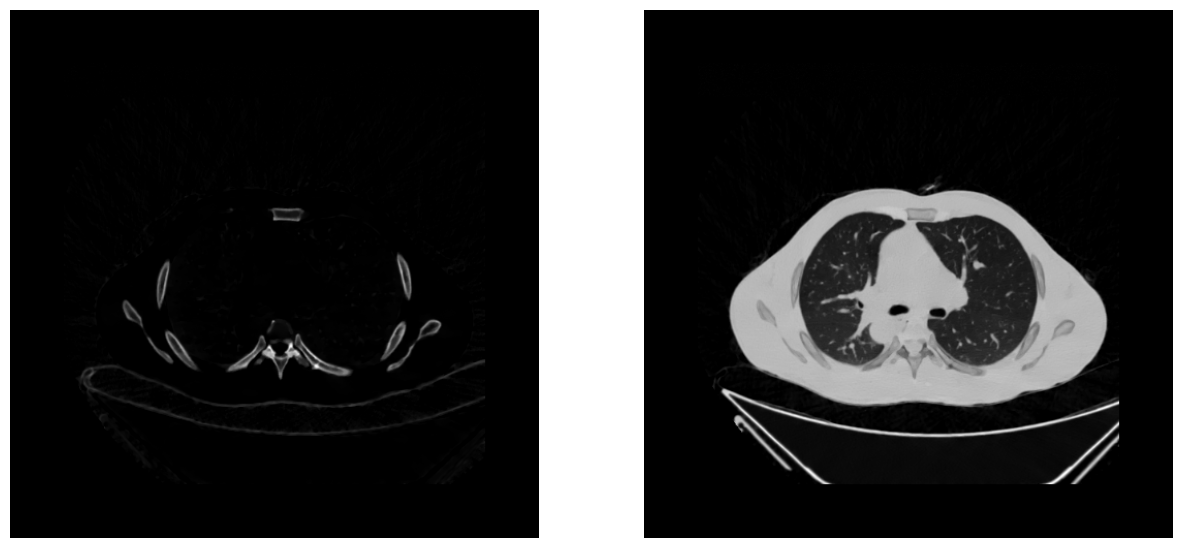

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
from Utils.my_utils_ddpm import diffusion_parameters, reverse_diffusion, reverse_diffusion_from_x_pred
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from Data.DataLoader_material import DataLoader_material
from Utils.my_utils_ddpm import diffusion_parameters, diffusion, reverse_diffusion, x_pred
from Utils.my_utils_radon import get_filter, filter_sinogram
from torch_radon import Radon, RadonFanbeam
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Diffusion model parameters
T = 1000
alpha, alpha_bar = diffusion_parameters(T)
sigma2 = (1-alpha)*(1-alpha_bar/alpha)/(1-alpha_bar)

# Image parameters
img_size = 512
n_mat = 2

# Loading reference image
pixel_size = 0.1
energy_list = [40,80,120]
patient_list_val = [10]

# Transforms to apply to images (resize, data augmentation, ..)      
my_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomApply([transforms.RandomRotation((180, 180))], p=1)] 
)

# Val dataset
material_list = ['Bones', 'Soft Tissues']
patient_list_val = [10]
data_val = DataLoader_material(img_dir ='Data/', material_list=material_list, patient_list=patient_list_val, transform=my_transforms)
Data_loader_val = DataLoader(data_val, batch_size=1, shuffle=True)

x_true_mat, index = next(iter(Data_loader_val))
x_true_mat =  x_true_mat.float().to(device)
x_true_mat_np = x_true_mat.detach().cpu().numpy()

# Display x materials :
fig, ax = plt.subplots(1,n_mat, figsize=(15,10))
for k in range(n_mat):
    ax[k].imshow(x_true_mat_np[0,k], cmap='gray')
    ax[k].axis('off')
plt.show()

In [2]:
# Loading the full spectrum incident
import pandas
from Utils.forward_model import *
df = pandas.read_csv('csv_files/spectral_incident.csv')
S = torch.tensor(df['120_keV']).to(device)

# Creating a binned spectrum
bin_list= [10,40,60,120]
prop_factor = 0.1
n_bin, binned_spectrum, E_k, S_k = create_bins(S,bin_list, prop_factor, device )

# Creating the material mass attenuation matrix
Q, Q_pseudo_spectral, x_mass_density, rho = create_mass_attenuation_matrix(E_k, x_true_mat, pixel_size, device)

# Torch Radon
radon = create_radon_op(img_size=img_size, n_angles=120, max_angle=np.pi, geom='parallel', device=device)
# radon = create_radon_op(img_size=img_size, n_angles=120, max_angle=2*np.pi, geom='fanbeam') 

# Forward material operator
background = 0
Y = forward_mat_op(x_mass_density, Q, binned_spectrum, background, radon, True, device)


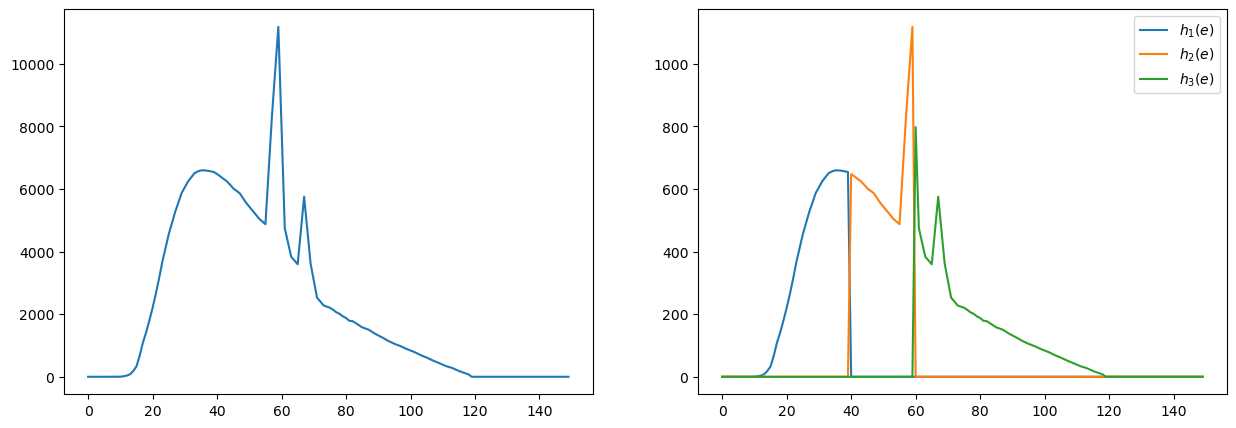

Somme dans chaque bins : tensor([112207.4531, 127343.3438, 105394.7344])
Energie moyenne de chaque bins : tensor([30, 50, 76])


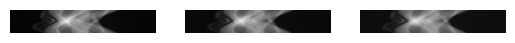

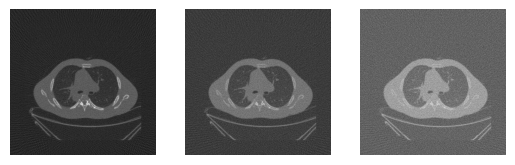

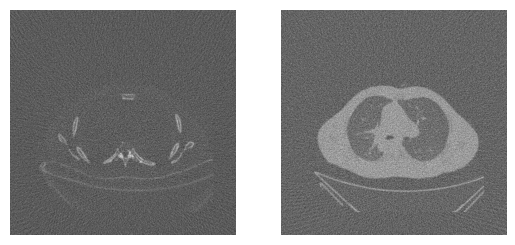

In [3]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(prop_factor*S.detach().cpu().numpy())
for k in range(len(bin_list)-1):
    ax[1].plot(binned_spectrum[k].detach().cpu().numpy(), label=f"$h_{{{k+1}}}(e)$")
plt.legend()
plt.show()
print(f'Somme dans chaque bins : {S_k.detach().cpu()}')
print(f'Energie moyenne de chaque bins : {E_k.detach().cpu()}')


sino_approx_spectral = torch.log(torch.sum(binned_spectrum, dim=1)[:,None,None]/Y)
sino_approx_spectral[Y==0] = 0
sino_approx_spectral = sino_approx_spectral[None]
fbp = radon.backward(filter_sinogram(sino_approx_spectral))


x_scout_recon = torch.linalg.lstsq(Q_pseudo_spectral, 
                            fbp[0,:].reshape(n_bin, img_size**2),
                            driver="gels").solution.reshape(2, img_size, img_size)[None,:,:,:]

# Computing metrics
PSNR_fbp_pinv = np.zeros(n_mat)
SSIM_fbp_pinv = np.zeros(n_mat)
for k in range(n_mat):
    PSNR_fbp_pinv[k] = peak_signal_noise_ratio(x_mass_density.detach().cpu().numpy()[0,k],x_scout_recon[0,k].detach().cpu().numpy(),data_range=x_mass_density[0,k].detach().cpu().numpy().max())
    SSIM_fbp_pinv[k] = structural_similarity(x_scout_recon[0,k].detach().cpu().numpy(), x_mass_density[0,k].detach().cpu().numpy(), data_range=x_mass_density[0,k].detach().cpu().numpy().max(), gradient=False)

    
fig, ax = plt.subplots(1,n_bin)
for k in range(n_bin):
    ax[k].imshow(sino_approx_spectral.detach().cpu()[0,k], cmap='gray')
    ax[k].axis('off')
plt.show()
    
fig, ax = plt.subplots(1,n_bin)
for k in range(n_bin):
    ax[k].imshow(fbp.detach().cpu()[0,k], cmap='gray')
    ax[k].axis('off')
plt.show()

fig, ax = plt.subplots(1,2)
for k in range(2):
    ax[k].imshow(x_scout_recon.detach().cpu()[0,k], cmap='gray')
    ax[k].axis('off')
plt.show()

## PWLS + Pseudo inv

Init
Starting PWLS


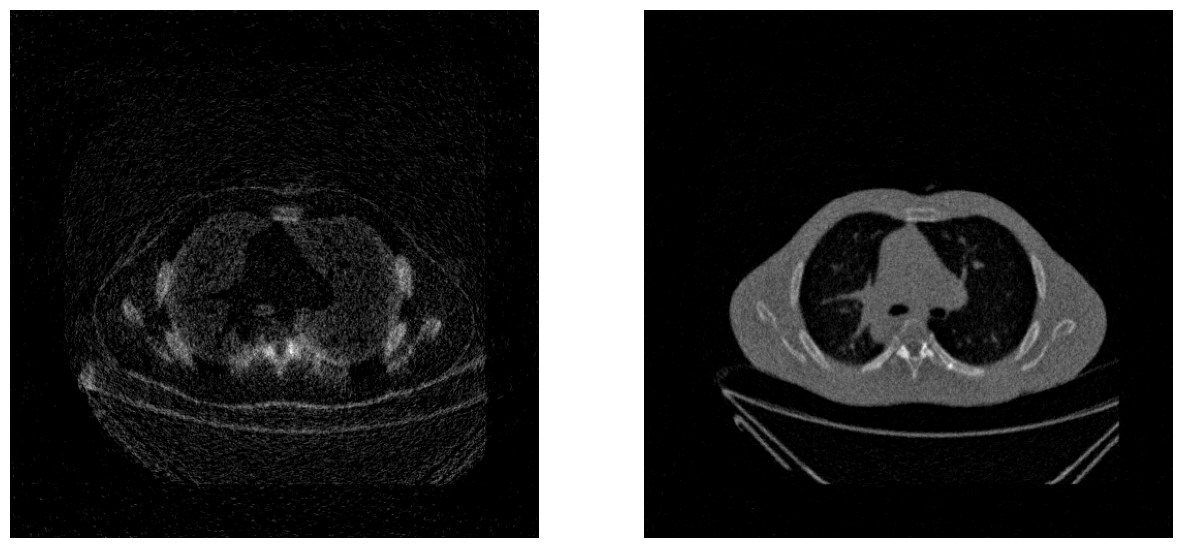

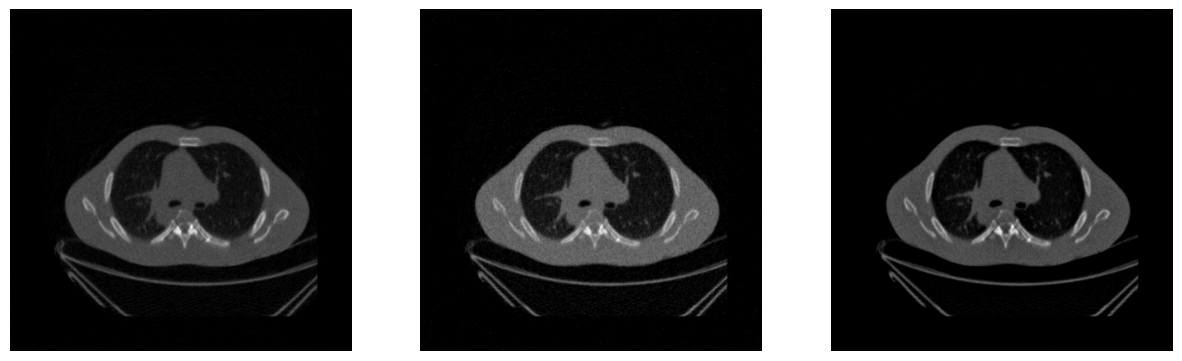

In [13]:
from Utils.PWLS import PWLS
# PWLS
n_iter = 200
delta = 0.1
beta_prior = torch.tensor([1e6,1e9,1e10], device=device)


init = torch.zeros(1,n_bin,img_size,img_size, device=device)
x_mat_pwls, x_spec_pwls, PSNR_pwls, SSIM_pwls = PWLS(init, Y, sino_approx_spectral, pixel_size, background, x_mass_density, n_iter, delta, beta_prior, radon, Q_pseudo_spectral, device)

x_pwls_np = x_mat_pwls.detach().cpu().numpy()

fig, ax = plt.subplots(1,n_mat, figsize=(15,15))
for k in range(n_mat):
    ax[k].imshow(x_pwls_np[0,k], cmap='gray')
    ax[k].axis('off')
plt.show()

fig, ax = plt.subplots(1,n_bin, figsize=(15,15))
for k in range(n_bin):
    ax[k].imshow(x_spec_pwls[0,k].detach().cpu().numpy(), cmap='gray')
    ax[k].axis('off')
plt.show()

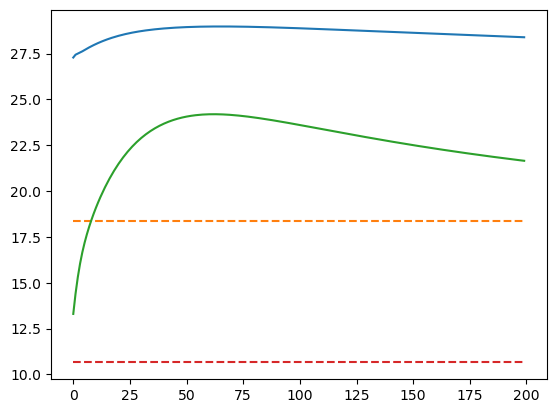

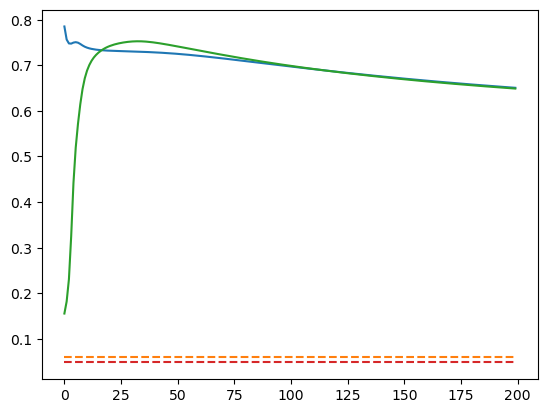

In [14]:
for k in range(n_mat):
    plt.plot(np.arange(n_iter), PSNR_pwls[:,k])
    plt.plot(np.arange(n_iter), PSNR_fbp_pinv[k]*np.ones(n_iter), '--')
plt.show()
for k in range(n_mat):
    plt.plot(np.arange(n_iter), SSIM_pwls[:,k])
    plt.plot(np.arange(n_iter), SSIM_fbp_pinv[k]*np.ones(n_iter), '--')
plt.show()

## With diffusion prior :

In [30]:
from neural_networks.UNet import UNet
material_nn = UNet(image_channels = 2, n_channels=32, n_blocks=2)
material_nn = material_nn.to(device)
ckpt_name = f"checkpoints_material/nn_weights/material_sept.pth"
material_nn.load_state_dict(torch.load(ckpt_name))

t_prime = 999

mean_material = torch.tensor(np.load('Data/mean_material.npy'), device=device, requires_grad=False)[None,:,None,None]
std_material = torch.tensor(np.load('Data/std_material.npy'), device=device, requires_grad=False)[None,:,None,None]

from Utils.ODPS import ODPS
# Init
step = torch.tensor([0.9,0.9], device=device)[None,:,None,None]

time : 111.93432188034058


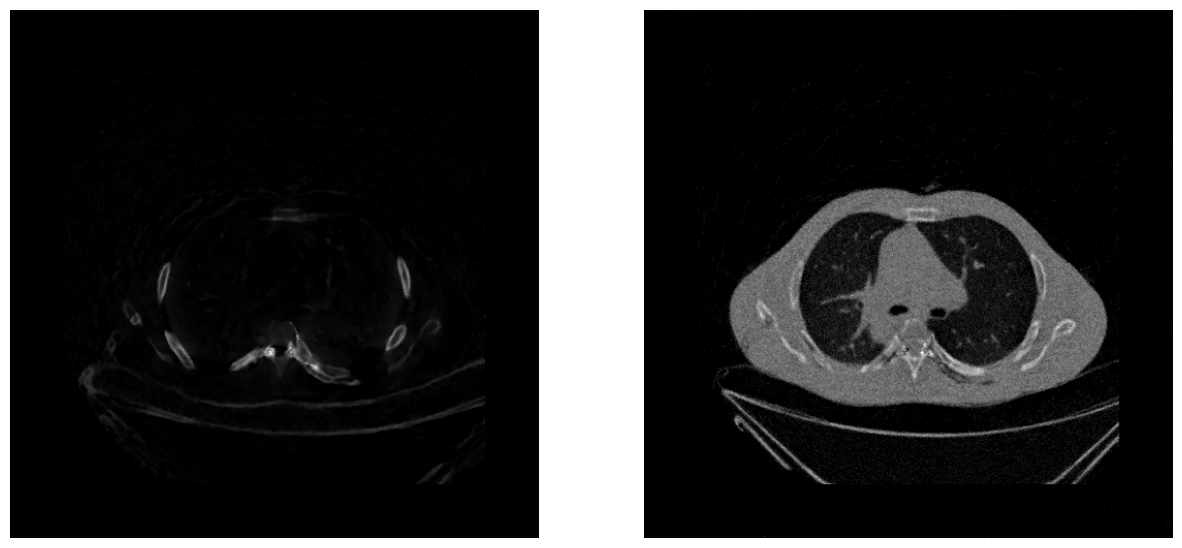

In [31]:
grad_approx = True
start = time.time()
x_odps_gradapprox, PSNR_odps_gradapprox, SSIM_odps_gradapprox = ODPS(Y, background, radon,
                                          binned_spectrum, Q, pixel_size, x_mass_density, rho,
                                          t_prime, step, x_scout_recon, material_nn, mean_material, 
                                          std_material, alpha, alpha_bar, sigma2, grad_approx, device)
end = time.time()
print(f'time : {end-start}')
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(x_odps_gradapprox[0,0].detach().cpu().numpy(), cmap='gray')
ax[0].axis('off')
ax[1].imshow(x_odps_gradapprox[0,1].detach().cpu().numpy(), cmap='gray')
ax[1].axis('off')
plt.show()

In [ ]:
grad_approx = False
start = time.time()
x_odps, PSNR_odps, SSIM_odps = ODPS(Y, background, radon,
                                          binned_spectrum, Q, pixel_size, x_mass_density, rho,
                                          t_prime, step, x_scout_recon, material_nn, mean_material, 
                                          std_material, alpha, alpha_bar, sigma2, grad_approx, device)
end = time.time()
print(f'time : {end-start}')
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(x_odps[0,0].detach().cpu().numpy(), cmap='gray')
ax[0].axis('off')
ax[1].imshow(x_odps[0,1].detach().cpu().numpy(), cmap='gray')
ax[1].axis('off')
plt.show()

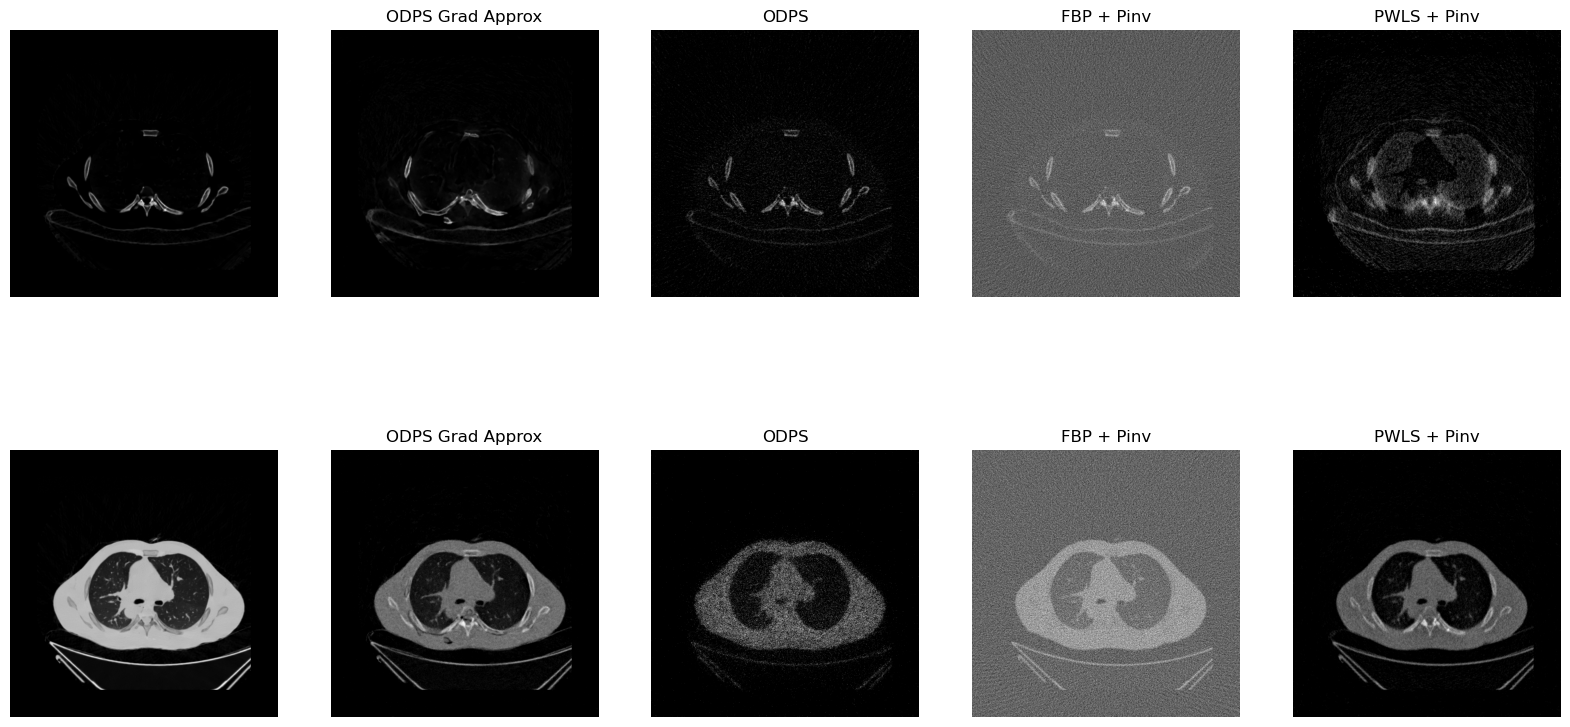

In [29]:
fig, ax = plt.subplots(2,5, figsize=(20,10))
for k in range(2):
    ax[k,0].imshow(x_true_mat_np[0,k], cmap='gray')
    ax[k,1].imshow(x_odps_gradapprox[0,k].detach().cpu(), cmap='gray')
    ax[k,1].set_title(f"ODPS Grad Approx")
    ax[k,2].imshow(x_odps[0,k].detach().cpu(), cmap='gray')
    ax[k,2].set_title(f"ODPS")
    ax[k,3].imshow(x_scout_recon.detach().cpu()[0,k], cmap='gray')
    ax[k,3].set_title(f"FBP + Pinv")
    ax[k,4].imshow(x_pwls_np[0,k], cmap='gray')
    ax[k,4].set_title(f"PWLS + Pinv")
    ax[k,0].axis('off')
    ax[k,1].axis('off')
    ax[k,2].axis('off')
    ax[k,3].axis('off')
    ax[k,4].axis('off')
plt.show()

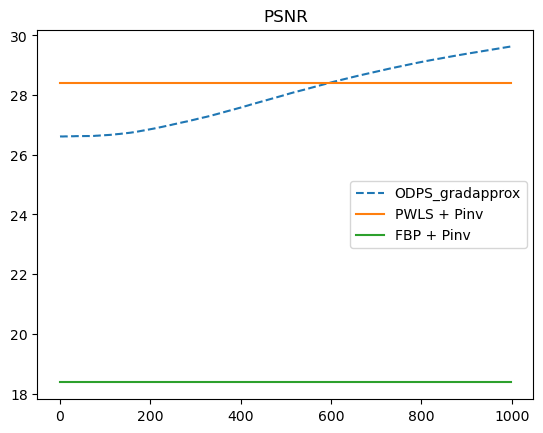

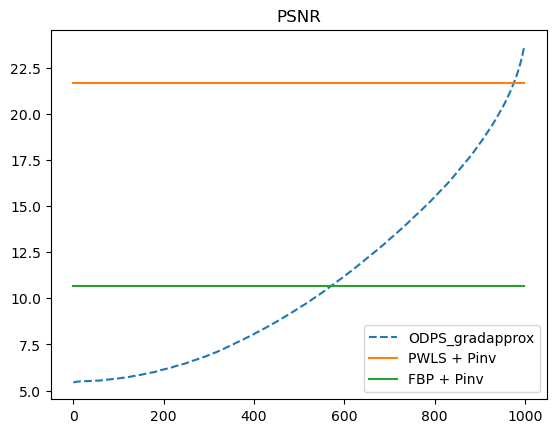

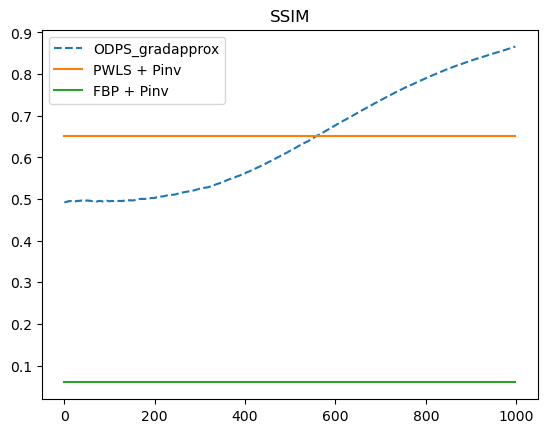

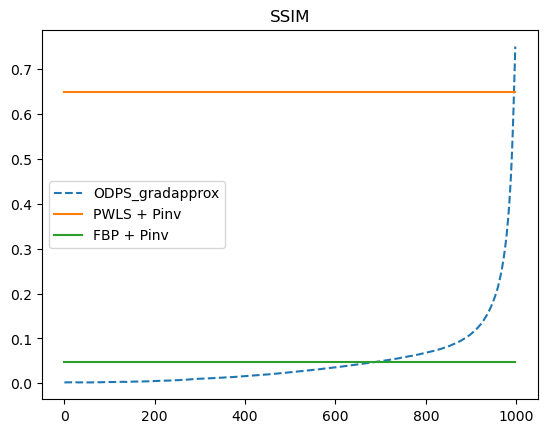

In [28]:
for k in range(n_mat):
    
#     plt.plot(np.arange(t_prime), PSNR_odps[:,k], label='ODPS')
    plt.plot(np.arange(t_prime), PSNR_odps_gradapprox[:,k],'--',label='ODPS_gradapprox')
    plt.plot(np.arange(t_prime), PSNR_pwls[-1,k]*np.ones(t_prime), label='PWLS + Pinv' )
    plt.plot(np.arange(t_prime), PSNR_fbp_pinv[k]*np.ones(t_prime), label='FBP + Pinv')
    plt.legend()
    plt.title('PSNR')
    plt.show()
    
for k in range(n_mat):
#     plt.plot(np.arange(t_prime), SSIM_odps[:,k], label='ODPS')
    plt.plot(np.arange(t_prime), SSIM_odps_gradapprox[:,k],'--',label='ODPS_gradapprox')
    plt.plot(np.arange(t_prime), SSIM_pwls[-1,k]*np.ones(t_prime), label='PWLS + Pinv' )
    plt.plot(np.arange(t_prime), SSIM_fbp_pinv[k]*np.ones(t_prime), label='FBP + Pinv')
    plt.legend()
    plt.title('SSIM')
    plt.show()